In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import timedelta
import matplotlib.dates as mdates
from calendar import month_abbr
import calendar



In [3]:
# Read the data
df = pd.read_csv('day_ahead_energy_prices.csv', parse_dates=['Datetime'])
'''
# Filter data for the last 6 months
end_date = df['Datetime'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)
 '''
df



,Datetime,hourly day-ahead energy price
0,2024-10-29 22:00:00+00:00,103.09
1,2024-10-29 21:00:00+00:00,118.08
2,2024-10-29 20:00:00+00:00,124.05
3,2024-10-29 19:00:00+00:00,140.60
4,2024-10-29 18:00:00+00:00,203.82
...,...,...
83876,2018-10-01 02:00:00+00:00,47.59
83877,2018-10-01 01:00:00+00:00,47.38
83878,2018-10-01 00:00:00+00:00,51.41
83879,2018-09-30 23:00:00+00:00,56.10


In [4]:
# Rename columns for Prophet 
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Ensure the datetime column is correctly formatted
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.tz_localize(None)  # Remove timezone information


<function matplotlib.pyplot.show(close=None, block=None)>

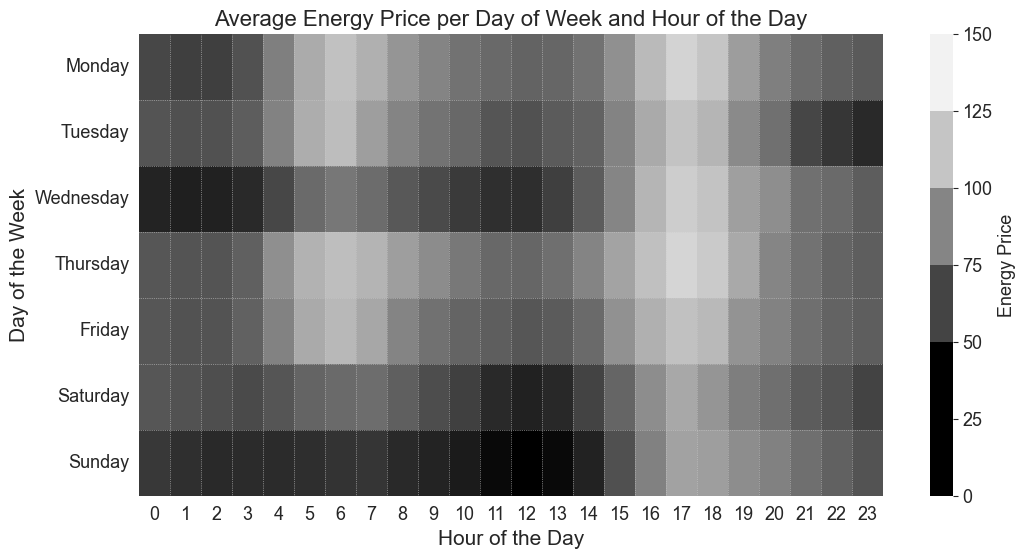

In [5]:
# Extract day of the week and hour
df['day_of_week'] = df['ds'].dt.dayofweek
df['hour'] = df['ds'].dt.hour

# Calculate the average energy price for each day-hour combination
hour_week = df.pivot_table(index='day_of_week', columns='hour', values='y', aggfunc='mean')

# Plotting the Heatmap
f, ax = plt.subplots(figsize=(12, 6))

# Customize the heatmap
sns.heatmap(hour_week, ax=ax, cmap='Greys_r', vmax=150, cbar_kws={'boundaries': np.arange(0, 160, 25)})

# Customize color bar font size and label
cbax = f.axes[1]
[lab.set_fontsize(13) for lab in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('Energy Price', fontsize=13)

# Add grid lines for day and hour separation
[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)]

# Set title and axis labels
ax.set_title('Average Energy Price per Day of Week and Hour of the Day', fontsize=16)
ax.set_xlabel('Hour of the Day', fontsize=15)
ax.set_ylabel('Day of the Week', fontsize=15)

# Customize tick labels to show full weekday names
ax.set_yticklabels([calendar.day_name[i] for i in range(7)], rotation=0)

# Customize tick label font sizes
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# Save the plot in multiple formats
for ext in ['png', 'jpeg', 'pdf']: 
    f.savefig(f'energy_dayofweek_hourofday.{ext}', dpi=200)

plt.show

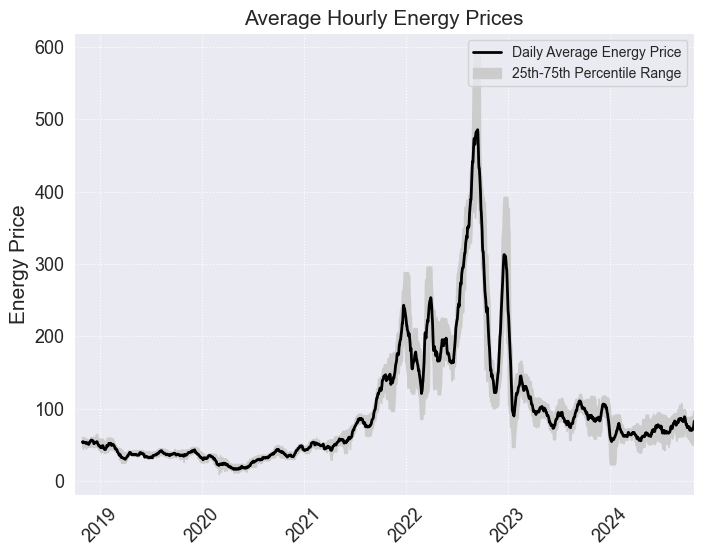

In [6]:
# Ensure 'ds' is set as the index
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# Calculate the 30-day rolling mean and 25th, 75th percentiles
seas_energy = df['y'].resample('D').mean().rolling(window=30).mean()
q25 = df['y'].resample('D').mean().rolling(window=30).quantile(0.25)
q75 = df['y'].resample('D').mean().rolling(window=30).quantile(0.75)

# Monthly ticks for x-axis
ndays_m = pd.date_range(df.index.min(), df.index.max(), freq='MS')  # 'MS' gives the start of each month
ndays_m = [date for date in ndays_m if date.month % 1 == 0]  # Keep every month for tick labels

# Plot
f, ax = plt.subplots(figsize=(8, 6))

# Line plot for the daily average energy price
seas_energy.plot(ax=ax, lw=2, color='k', legend=False, label='Daily Average Energy Price')

# Shaded area between 25th and 75th percentile values
ax.fill_between(seas_energy.index, q25, q75, color='0.8', label='25th-75th Percentile Range')

# Set the x-axis ticks to show years only
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to show the year only

# Optional: Rotate the year labels if needed
ax.tick_params(axis='x', rotation=45)

# Grid and labels
ax.grid(ls=':')
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Energy Price', fontsize=15)

# Customize tick labels
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# Title
ax.set_title('Average Hourly Energy Prices', fontsize=15)

# Save the plot in multiple formats
for ext in ['png', 'jpeg', 'pdf']: 
    f.savefig(f'energy_seasonal_cycle.{ext}', dpi=200)

plt.legend()
plt.show()


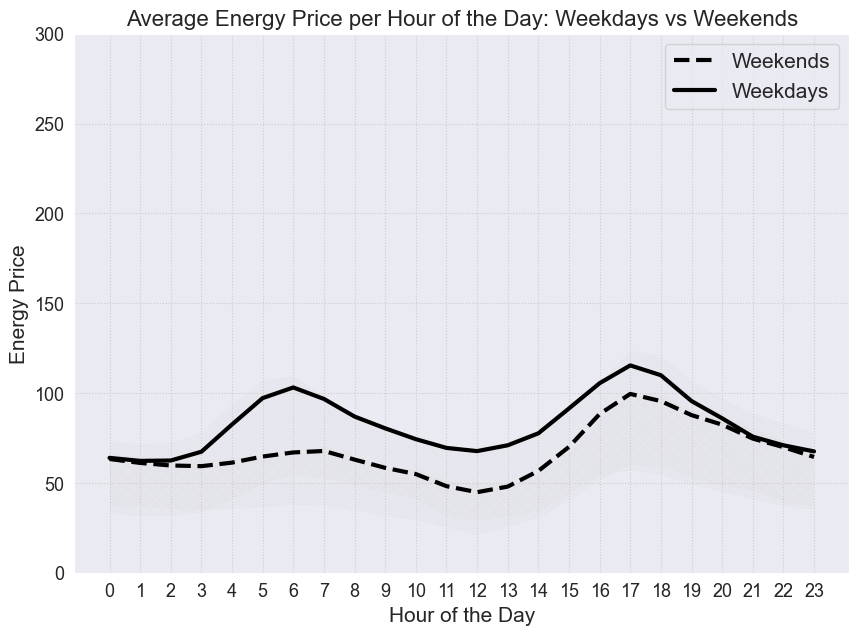

In [7]:
# Assuming 'df' is your DataFrame with 'ds' as datetime and 'y' as energy price.
df = pd.read_csv('day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)
df.set_index('ds', inplace=True)

# Separate weekdays and weekends
weekdays = df.loc[df.index.weekday < 5, 'y']  # Monday to Friday (weekday < 5)
weekends = df.loc[df.index.weekday >= 5, 'y']  # Saturday and Sunday (weekday >= 5)

# Summarize by hour for weekdays and weekends
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

# Plotting
f, ax = plt.subplots(figsize=(10, 7))

# Plot for weekends
ax.plot(summary_hour_weekends.index, summary_hour_weekends['mean'], color='k', label='Weekends', ls='--', lw=3)
ax.fill_between(summary_hour_weekends.index, summary_hour_weekends['25%'], summary_hour_weekends['75%'], 
                hatch='///', facecolor='0.8', alpha=0.1)

# Plot for weekdays
ax.plot(summary_hour_weekdays.index, summary_hour_weekdays['mean'], color='k', label='Weekdays', lw=3)
ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays['25%'], summary_hour_weekdays['75%'], 
                hatch='\\\\\\', facecolor='0.8', alpha=0.1)

# Configure x-axis and grid
ax.set_xticks(range(24))
ax.grid(ls=':', color='0.8')

# Set labels and title
ax.set_xlabel('Hour of the Day', fontsize=15)
ax.set_ylabel('Energy Price', fontsize=15)
ax.set_title('Average Energy Price per Hour of the Day: Weekdays vs Weekends', fontsize=16)

# Customize tick label font sizes
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# Set y-axis limit for clarity if needed
ax.set_ylim([0, 300])  # Adjust as per your data range

# Add legend
ax.legend(loc='upper right', fontsize=15)

# Save the plot in multiple formats
for ext in ['png', 'jpeg', 'pdf']: 
    f.savefig(f'energy_daily_cycle_{ext}', dpi=200)

plt.show()
